In [28]:
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import fnmatch
import os
import dlib
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine
from scipy.cluster.hierarchy import dendrogram, linkage
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Read MSDS student and faculty profile images

In [14]:
# To get student images
!wget -K -p https://www.usfca.edu/arts-sciences/graduate-programs/data-science/our-students

# To get faculty images
!wget -K -p https://www.usfca.edu/arts-sciences/graduate-programs/data-science/faculty

In [2]:
# Then downloaded images will in the following folders.

student_folder = 'www.usfca.edu/sites/default/files/images/headshots/'
faculty_folder = 'www.usfca.edu/sites/default/files/styles/student_profile_500x500/public/images/headshots/'

In [3]:
def filelist(root):
    """
    Return a fully-qualified list of filenames under root directory
    Return just the filename
    """
    filepath = []
    filename = []
    pattern = '*.jpg'
    for path, subdirs, files in os.walk(root):
        for name in fnmatch.filter(files, pattern):
            filepath.append(os.path.join(path, name))
            filename.append(name)
    return filepath, filename

In [4]:
student_files, s_filename = filelist(student_folder)
faculty_files, f_filename = filelist(faculty_folder)

In [17]:
student_files[:5]

['www.usfca.edu/sites/default/files/images/headshots/msan-student-rodilla-jose-a.jpg',
 'www.usfca.edu/sites/default/files/images/headshots/msan-student-sooraj.jpg',
 'www.usfca.edu/sites/default/files/images/headshots/msan-student-peng-tina.jpg',
 'www.usfca.edu/sites/default/files/images/headshots/msan-student-csiszar-chris.jpg',
 'www.usfca.edu/sites/default/files/images/headshots/msan-student-bowers-devin.jpg']

In [18]:
s_filename[:5]

['msan-student-rodilla-jose-a.jpg',
 'msan-student-sooraj.jpg',
 'msan-student-peng-tina.jpg',
 'msan-student-csiszar-chris.jpg',
 'msan-student-bowers-devin.jpg']

In [8]:
print ("There are %s students in student folder and %s faculties in faculty folder" %(len(student_files), len(faculty_files)) )

There are 76 students in student folder and 15 faculties in faculty folder


## There are two ways to display image.
- Method 1: Create a popup window and display the image for specified seconds
- Method 1: Display the image in jupyter notebook

Below I'm using two methods to display image

In [9]:
# Method 1: images will be shown in a new popup window

for i in range(4):
    student_image = cv2.imread(student_files[i])
    cv2.imshow("Original", student_image)
    cv2.waitKey(1000)
    cv2.destroyAllWindows()

In [6]:
for i in range(4):
    student_image = cv2.imread(faculty_files[i])
    cv2.imshow("Original", student_image)
    cv2.waitKey(1000)
    cv2.destroyAllWindows()

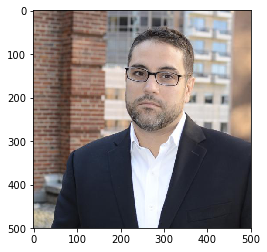

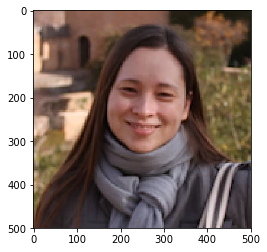

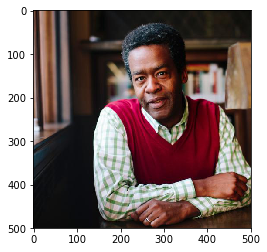

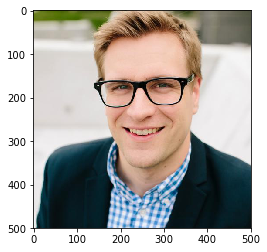

In [6]:
# Method 2: images will be displayed below in the notebook

def plot_four_images(filelist):
    for i in range(4):
        img=mpimg.imread(filelist[i])
        imgplot = plt.imshow(img)
        plt.show()
        
plot_four_images(faculty_files)

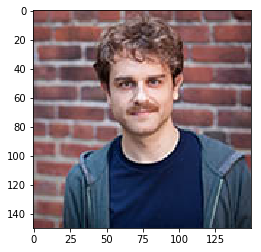

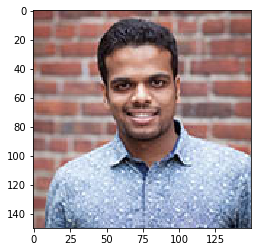

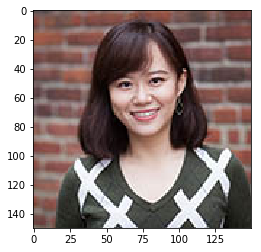

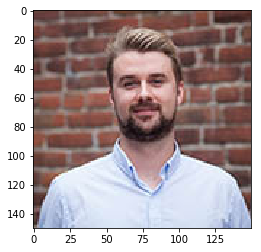

In [7]:
plot_four_images(student_files)

# Align faces using image registration method

In [5]:
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

def aligned_image(filepath,filename):
    img = cv2.imread(filepath)
    dets = detector(img, 2)
    faces = dlib.full_object_detections()
    for detection in dets:
        faces.append(sp(img,detection))
    images = dlib.get_face_chips(img, faces, size=320, padding=0.35)
    for image in images:
        cv2.imwrite(filename, image)

Write new aligned images to images folders

In [6]:
for i in range(76):
    aligned_image(student_files[i], 'images/students/'+ s_filename[i])
    
for i in range(15):
    aligned_image(faculty_files[i], 'images/faculties/'+ f_filename[i])

Display 4 students aligned faces and then 4 faculty faces, each one second

In [4]:
student_folder = 'images/students/'
faculty_folder = 'images/faculties/'

s_aligned,_ = filelist(student_folder)
f_aligned,_ = filelist(faculty_folder)

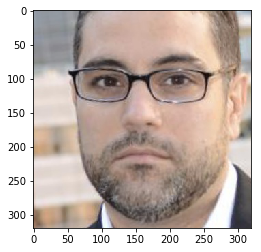

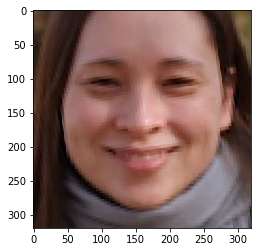

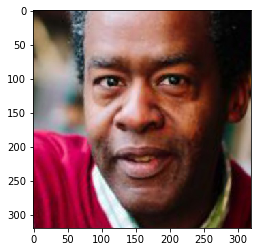

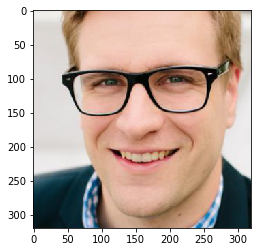

In [9]:
plot_four_images(f_aligned)

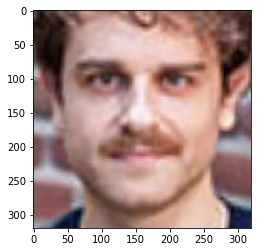

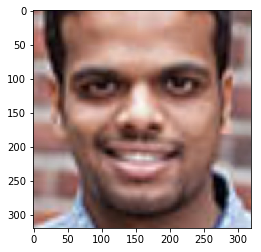

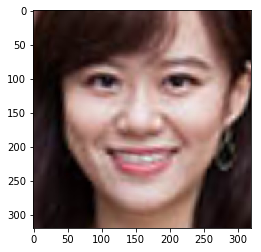

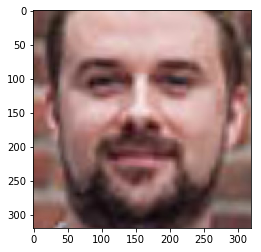

In [10]:
plot_four_images(s_aligned)

# Reconstruct student faces using PCA dimension reduction method

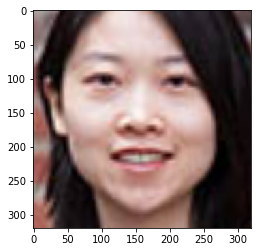

In [40]:
# This is my profile image

img=mpimg.imread(s_aligned[45])
imgplot = plt.imshow(img)
plt.show()

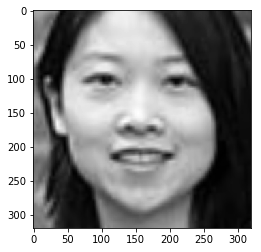

In [5]:
# Actually, we are using the black and white version, since color variance in each image will mess up with PCA

me_im = cv2.imread(s_aligned[45], 0)
plt.imshow(me_im,cmap='gray');

In [6]:
sz = me_im.shape
print ("The dimension of one grey image is %s by %s" %(sz))

The dimension of one grey image is 320 by 320


In [7]:
# construct an empty matrix to store image vectors, where each row represents a student

num_student = len(s_aligned)
student_matrix = np.zeros((num_student, sz[0] * sz[1]), dtype=np.float32)

print ("The dimension of the matrix is %s by %s" %(student_matrix.shape))

The dimension of the matrix is 76 by 102400


In [8]:
# fill the matrix

for i in range(num_student):
    im = cv2.imread(s_aligned[i], 0).astype('uint8')
    im = im.flatten()
    student_matrix[i, :] = im

means = np.mean(student_matrix, axis=0)
student_matrix -= means

### Average face in student group

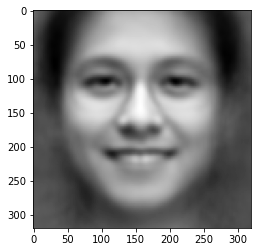

In [10]:
# Belive it or not, this is the average face of all students here in MSDS

plt.imshow(means.reshape(sz),cmap='gray')
plt.show()

## Use PCA to reduce dimension
- Method 1 is used below
- Method 2 is using cv2 module:

mean, eigenVectors = cv2.PCACompute(student_matrix, mean=None, maxComponents=4)

plt.imshow( (student_matrix.dot(eigenVectors.T)[:,i] + means).reshape(sz))

In [209]:
# Reduced 76 dimension to 4

student_pca = PCA(n_components=4)
weight = student_pca.fit_transform(student_matrix)

print ("The dimension of the student weight matrix is %s by %s" %(weight.shape))

The dimension of the student weight matrix is 76 by 4


In [172]:
eigenvectors = student_pca.components_

print ("The dimension of the eigenvectors is %s by %s" %(eigenvectors.shape))

The dimension of the eigenvectors is 4 by 102400


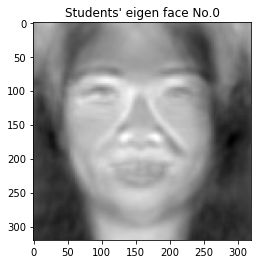

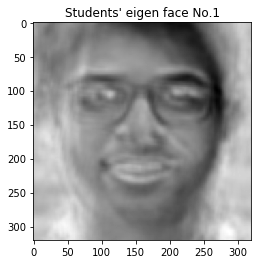

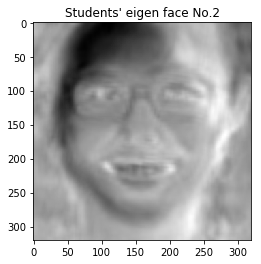

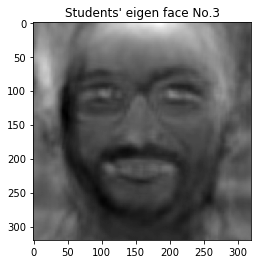

In [173]:
for i in range(4):
    plt.imshow(student_pca.components_[i].reshape(sz), cmap='gray')
    plt.title('Students\' eigen face No.%d'% i )
    plt.show()

In [210]:
print ("As a result, %.2f%% of variability do these four eigenfaces make up for the student population, which is pretty low" 
       %(100*student_pca.explained_variance_ratio_.sum()))

As a result, 51.31% of variability do these four eigenfaces make up for the student population, which is pretty low


## Reconstruct my face using 4 eigenfaces

In [174]:
student_pca.components_[:, 45] # my weights

array([-0.00202315, -0.00105568, -0.00106135,  0.00135238], dtype=float32)

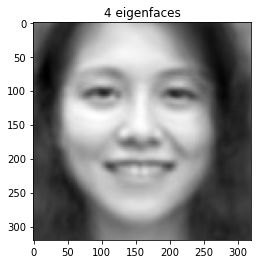

In [175]:
plt.imshow((student_pca.components_.T.dot(weight[45,:]) + means).reshape(sz), cmap='gray')
plt.title('4 eigenfaces');

## Reconstruct faces using higher dimension

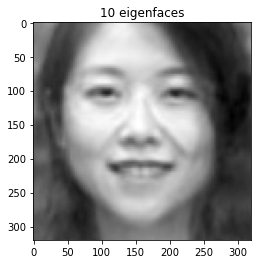

In [176]:
student_pca = PCA(n_components=10)
weight = student_pca.fit_transform(student_matrix)
plt.imshow((student_pca.components_.T.dot(weight[45,:]) + means).reshape(sz), cmap='gray')
plt.title('10 eigenfaces');

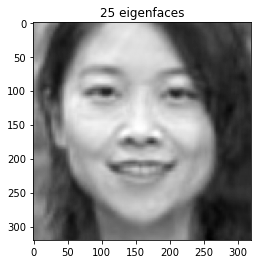

In [9]:
student_pca = PCA(n_components=25)
weight = student_pca.fit_transform(student_matrix)
plt.imshow((student_pca.components_.T.dot(weight[45,:]) + means).reshape(sz), cmap='gray')
plt.title('25 eigenfaces');

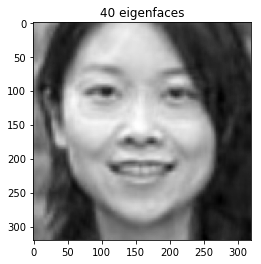

In [178]:
student_pca = PCA(n_components=40)
weight = student_pca.fit_transform(student_matrix)
plt.imshow((student_pca.components_.T.dot(weight[45,:]) + means).reshape(sz), cmap='gray')
plt.title('40 eigenfaces');

#### As you can see,  with higher dimension of PCA components, the reconstrctued face look more like me. But there's not much difference between 25 components and 40 components. So I will use reconstructed faces with 25 components.

#### Why do we need PCA dimension reduction before clustering? Because it remove noise.

In [12]:
print ("As a result, %.2f%% of variability do these 25 eigenfaces make up for the student population." 
       %(100*student_pca.explained_variance_ratio_.sum()))

As a result, 85.15% of variability do these 25 eigenfaces make up for the student population.


In [10]:
# save reconstructed faces
student_matrix_new = student_pca.components_.T.dot(weight.T) + means.reshape(-1,1)

print ("The dimension of the new student matrix is %s by %s" %(student_matrix_new.shape))

The dimension of the new student matrix is 102400 by 76


# Repeat same process for faculty images

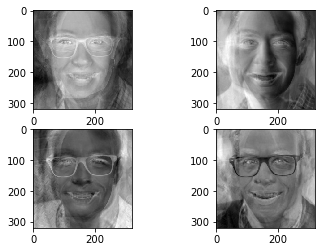

In [11]:
num_faculty = len(f_aligned)
faculty_matrix = np.zeros((num_faculty, sz[0] * sz[1]), dtype=np.float32)

# read images to matrix
for i in range(num_faculty):
    im = cv2.imread(f_aligned[i], 0).astype('uint8')
    im = im.flatten()
    faculty_matrix[i, :] = im
    
fmeans = np.mean(faculty_matrix, axis=0)
faculty_matrix -= fmeans

faculty_pca = PCA(n_components=4)
weight = faculty_pca.fit_transform(faculty_matrix)

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(faculty_pca.components_[0].reshape(sz), cmap='gray')
axarr[0,1].imshow(faculty_pca.components_[1].reshape(sz), cmap='gray')
axarr[1,0].imshow(faculty_pca.components_[2].reshape(sz), cmap='gray')
axarr[1,1].imshow(faculty_pca.components_[3].reshape(sz), cmap='gray')
plt.show()

In [15]:
print ("As a result, %.2f%% of variability do these 4 eigenfaces make up for the faculty population." 
       %(100*faculty_pca.explained_variance_ratio_.sum())) 

As a result, 76.96% of variability do these 4 eigenfaces make up for the faculty population.


## Reconstruct faculty faces

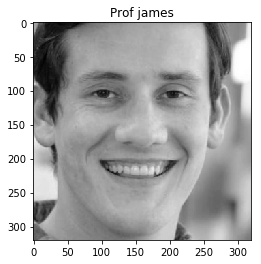

In [163]:
james_im = cv2.imread(f_aligned[10], 0)
plt.imshow(james_im,cmap='gray')
plt.title('Prof james');

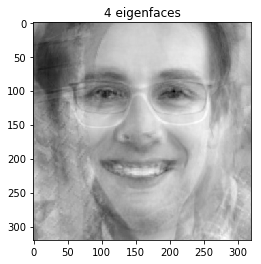

In [165]:
plt.imshow((faculty_pca.components_.T.dot(weight[10,:]) + fmeans).reshape(sz),cmap='gray')
plt.title('4 eigenfaces');

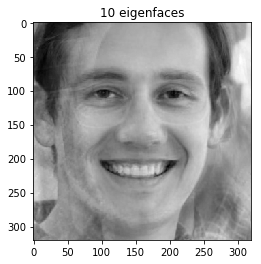

In [12]:
faculty_pca = PCA(n_components=10)
weight = faculty_pca.fit_transform(faculty_matrix)
plt.imshow((faculty_pca.components_.T.dot(weight[10,:]) + fmeans).reshape(sz),cmap='gray')
plt.title('10 eigenfaces');

In [211]:
print ("As a result, %.2f%% of variability do these 10 eigenfaces make up for the faculty population." 
       %(100*faculty_pca.explained_variance_ratio_.sum())) 

As a result, 94.49% of variability do these 10 eigenfaces make up for the faculty population.


In [13]:
# 10 is a good number. So again, save the reconstructed faces.

faculty_matrix_new = faculty_pca.components_.T.dot(weight.T) + fmeans.reshape(-1,1)

print ("The dimension of the new faculty matrix is %s by %s" %(faculty_matrix_new.shape))

The dimension of the new faculty matrix is 102400 by 15


# Construct adjacency matrix on constructed face and draw the network plot

In [14]:
# stack student and faculty matrix

all_matrix = np.hstack((student_matrix_new, faculty_matrix_new))

In [18]:
# construct cosine similarity matrix
cosine_similarity_matrix = np.zeros((91, 91), dtype=np.float32)

for i in range(91):
    for j in range(91):
        if i==j:
            cosine_similarity_matrix[i,j] = 0
        else:
            cosine_similarity_matrix[i,j] =1 - cosine(all_matrix[:,i], all_matrix[:,j])

In [182]:
# get people's name from file
name_dict = {}
for i in range(76):
    name_dict[str(i)] = ' '.join(s_filename[i].split('.')[0].split('-')[-2:])
for i in range(76, 91):
    name_dict[str(i)] = ' '.join(f_filename[i-76].split('.')[0].split('-'))

In [199]:
# the function is to draw the network with name as labels.
# Only pairs with similarity score bigger than 0.95 is shown

def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix > 0.95)
    rows = [name_dict[str(i)] for i in rows]
    cols = [name_dict[str(i)] for i in cols]
    edges = zip(rows, cols)
    gr = nx.Graph()
    gr.add_edges_from(edges)
    pos = nx.spring_layout(gr)
    nx.draw(gr, node_size=300, with_labels=True, pos=pos)
    plt.show()

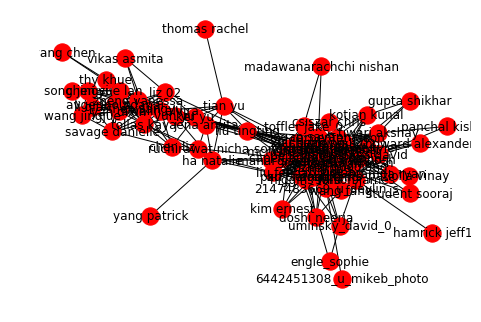

In [200]:
show_graph_with_labels(cosine_similarity_matrix)

### One fun question: Who is Prof James most similar to in reconstructed faces - Solve in a brutal way

In [201]:
np.argmax(cosine_similarity_matrix[86,])

22

In [202]:
name_dict['86'], name_dict['22']

('wilson james', 'smeenk ian')

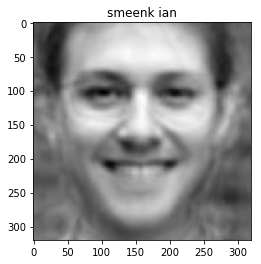

In [204]:
plt.imshow(all_matrix[:,22].reshape(sz),cmap='gray')
plt.title('smeenk ian');

# K-means clutering 
### find the right number of clusters by Elbow Analysis

In [30]:
cluster_range = range(1, 7)
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans(num_clusters)
    clusters.fit(all_matrix)
    cluster_errors.append(clusters.inertia_ )

In [31]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df

,cluster_errors,num_clusters
0,2.974500e+10,1
1,1.632613e+10,2
2,1.385102e+10,3
3,1.248626e+10,4
4,1.148632e+10,5
5,1.068503e+10,6


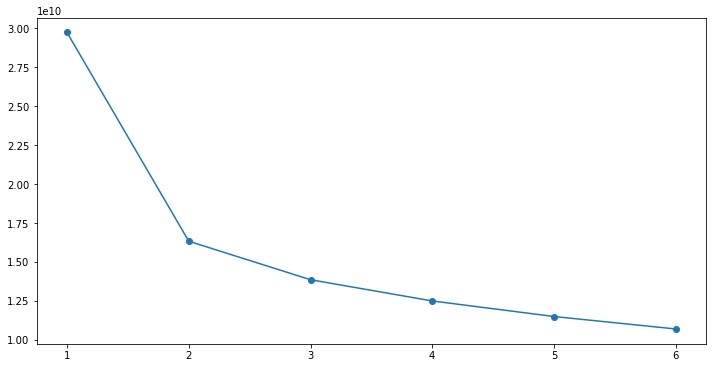

In [32]:
# elbow diagram
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

The elbow diagram shows that the gain in explained variance reduces significantly from 2 to 3 to 4. So, optimal number of clusters could be 3 or 4. So the profile pictures might have 3 or 4 clusters of different faces.

# Hierarchical Clustering and dendrogram

In [19]:
all_matrix.shape

(102400, 91)

In [15]:
# generate the linkage matrix
# Since each observation is high-dimensional, I would use cosine as the metric

Z = linkage(all_matrix.T, method='single', metric = 'cosine')

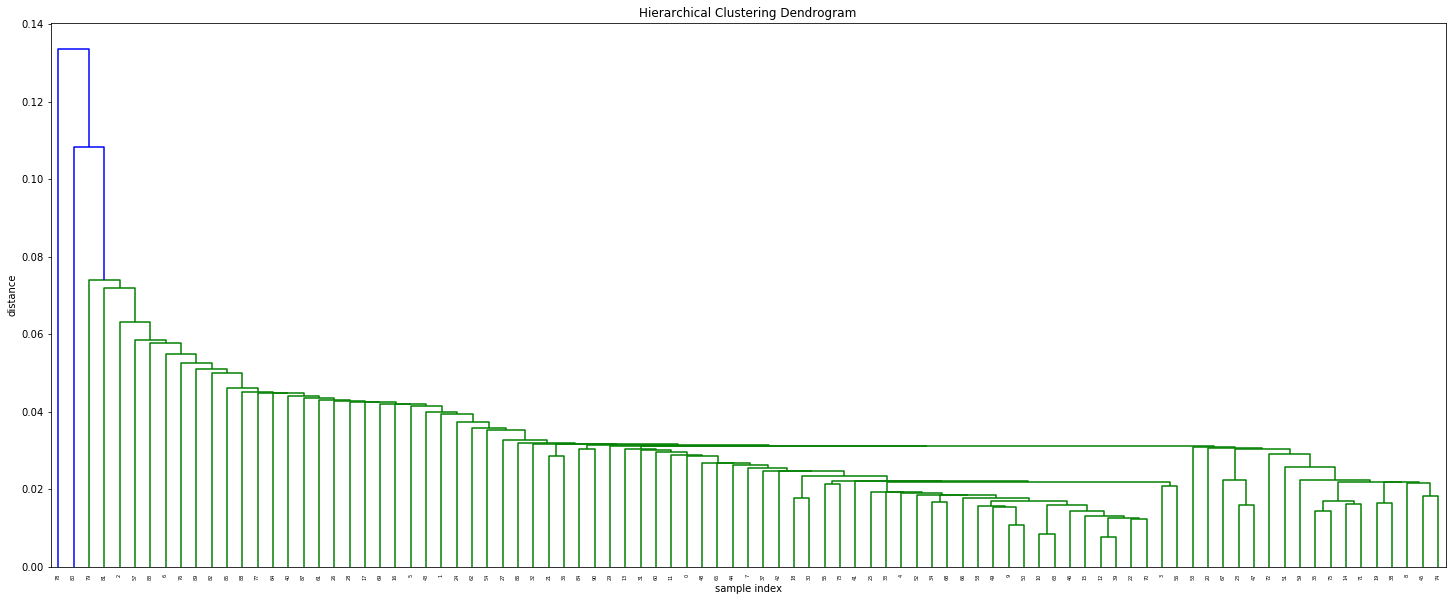

In [23]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

dn = dendrogram(Z)
plt.show()